# Project - Moving Average Crossover Parameter Optimization

    This notebook showcases the logic behind finding optimal trading parameters for a given strategy. First, we will show results for what an in-sample optimization/walk-forward analysis looks like and discuss pitfalls of this approach. Next, we will discuss remedies for how we can avoid overfitting a trading model, specifically by using stochastic differential equations to simulate time series. Lastly, we will show how we can optimize our trading strategies on each individual time series in order to determine trading parameters that would perform best out of sample. 

### Import packages that we will need

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
from numba import njit
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.special import logsumexp

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['lines.linewidth'] = 1

plt.style.use('dark_background')

### Define functions that we will use in our analysis

In [2]:
#Garman Klass Vol
def calculate_rogers_satchell_volatility(price_data: pd.DataFrame, window: int, trading_periods: int, clean: bool) -> pd.Series:
    '''
    The purpose of this function is to calculate the Rogers-Satchell volatility of a timeseries of open, high, low, and closing prices of a security. The rationale behind using this 
    estimator is to account for open, high, low, and close prices when calculating candle volatility, and also to account for trending markets. The estimator doesn't account price movements
    between trading sessions however, since we are trading crypto, there aren't overnight jumps to account for. More information can be found here: https://portfolioslab.com/tools/rogers-satchell
    
    :param price_data: pandas dataframe containing price data with ohlc formatted as price_open, price_high, price_low, price_close
    :param window: lookback window for volatility calculation
    :param trading_period: annualization factor
    :param clean: if we want to drop NaNs
    '''
    #create a copy of our price data to avoid changing original data
    price_data = price_data.copy()
    #make necessary calculatoins
    log_ho = (price_data['price_high'] / price_data['price_open']).apply(np.log)
    log_lo = (price_data['price_low'] / price_data['price_open']).apply(np.log)
    log_co = (price_data['price_close'] / price_data['price_open']).apply(np.log)
    #formula
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean())**0.5
    
    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)
    
    if clean:
        return result.dropna()
    else:
        return result
    
    
def fit_ou_process(data: np.array, deltaT: float, log: bool) -> Tuple[float, float, float]:
    '''
    The purpose of this function is to fit an exponential ornstein uhlenbeck process to a given dataset using OLS. the function will return the parameters of the OU process, mu, theta, sigma.
    The paper on how to calibrate this model can be found here: https://advancesincontinuousanddiscretemodels.springeropen.com/articles/10.1186/s13662-018-1718-4 
    
    :param data: volatility array that we calculated using the calculate_rogers_satchell_volatility function
    :param deltaT: the annualized change in timestep where deltaT = 1 signifies 1 year
    '''
    #calculations described in function description
    if log:
        data = np.log(data)
    y = data[1:]
    X_ = data[:-1]
    m = sm.OLS(y, sm.add_constant(X_)).fit()
    a = m.params[1]
    b = m.params[0]
    e = np.std(m.resid)
    theta = - np.log(a) / deltaT
    mu_hat = b / (1 - a)
    sigma = e * np.sqrt((-2 * np.log(a)) / (deltaT * (1 - a**2)))
    mu = mu_hat + (sigma**2 / (2 * theta))
    
    return mu, theta, sigma
    

def get_next_ou_value(current_value: float, mu: float, theta: float, sigma: float, deltaT: float, rv: float, log: bool) -> float:
    '''
    The purpose of this function is to use the xou process parameters that we calibrated to simulate the next instananeous volatility value in a simulated time series. The formula for 
    this function is referenced as formula (9) in the paper: https://advancesincontinuousanddiscretemodels.springeropen.com/articles/10.1186/s13662-018-1718-4 
    
    :param current_value: current log instantaneous volatility value
    :params mu, theta, sigma: model parameters from fit ornstein uhlenbeck process
    :param deltaT: the annualized change in timestep where deltaT = 1 signifies 1 year
    :param rv: random variable with mean 0, variance 1, and correlation rho to spot returns
    
    returns the instantaneous volatility of the next period
    '''
    if log:
        return np.exp((current_value * np.exp(-theta * deltaT)) + (mu - (sigma**2)/(2*theta))*(1 - np.exp(-theta * deltaT)) + (sigma * np.sqrt((1/(2*theta)) * (1 - np.exp(-2 * theta * deltaT))) * rv))
    return (current_value * np.exp(-theta * deltaT)) + (mu - (sigma**2)/(2*theta))*(1 - np.exp(-theta * deltaT)) + (sigma * np.sqrt((1/(2*theta)) * (1 - np.exp(-2 * theta * deltaT))) * rv)


#write a quick helper function to simulate price paths after simulations vol paths

def get_next_price(current_value: float, vol: float, drift: float, deltaT: float, rv:float) -> float:
    '''
    The purpose of this function is to use gbm with no drift term to simulate the next price in a simulated price series using the simulated instantaneous volatility as our volatility
    parameter. The formula is referenced here: https://stats.libretexts.org/Bookshelves/Probability_Theory/Probability_Mathematical_Statistics_and_Stochastic_Processes_(Siegrist)/18%3A_Brownian_Motion/18.04%3A_Geometric_Brownian_Motion
    
    return price of the next period
    '''
    return current_value * np.exp((drift - (vol**2)/2)*deltaT + (vol * rv * np.sqrt(deltaT)))


def generate_multivariable_normal(rho: float) -> Tuple[float, float]:
    '''
    This is a helper function that generates correlated random variables, which we will need for our price and volatility path simulations.
    
    returns two correlated standard normal random variables.
    '''
    dw1 = np.random.normal()
    dw2 = rho * dw1 + np.sqrt(1 - rho**2) * np.random.normal()
    return dw1, dw2

def HestonSimulation(initial_price: float, initial_vol: float, drift: float, mu: float, theta: float, sigma: float, deltaT: float, rho: float, rho_mu: float, rho_theta: float, rho_sigma: float, num_timesteps: int) -> Tuple[np.array, np.array, np.array]:
    '''
    This is a function that utilizes the helper functions above to simulate price, volatility, and rolling correlated paths.
    
    returns numpy arrays of simulted volatility paths, price paths, and rolling correlation paths
    '''
    price_array = np.array([initial_price])
    vol_array = np.array([initial_vol])
    rho_array = np.array([rho])
    for _ in range(num_timesteps):
        x, y =  generate_multivariable_normal(rho_array[-1])
        vol_array = np.append(vol_array, get_next_ou_value(np.log(vol_array[-1]), mu, theta, sigma, deltaT, x, True))
        price_array = np.append(price_array, get_next_price(price_array[-1], vol_array[-1], drift, deltaT, y))
        rho_array = np.append(rho_array, get_next_ou_value(rho_array[-1], rho_mu, rho_theta, rho_sigma, deltaT, np.random.normal(), False))

    return (vol_array, price_array, rho_array)

#Return Metrics
def CalculateSortino(returns: np.array) -> float:
    '''
    The Sortino ratio is a more robust measure of risk if your strategy isn't outright arbitrade becuse it doesn't penalize you for upside volatility. 
    '''
    mean = np.mean(returns)
    downside_vol = np.std(returns[returns < 0])
    return round((mean / downside_vol) * np.sqrt(48*365), 4)

def CalculateSharpe(returns: np.array) -> float:
    '''
    Sharpe ratio gives you a return per unit risk associated with your strategy.
    '''
    mean = np.mean(returns)
    vol = np.std(returns)
    return round((mean / vol) * np.sqrt(48*365), 4)

def CAGR(V_t: float, t: float) -> float:
    '''
    Compound annual growth rate
    '''
    return (logsumexp(V_t[-1]) ** logsumexp(1/t)) - 1

def CalculateCalmar(returns: np.array, cumulative_returns: np.array) -> float:
    '''
    The calmar ratio measures your average annualized return divided by your max drawdown. A high calmar may validate a strategy if the returns compensate for added risk.
    '''
    mean = np.mean(returns) * 48 * 365
    roll_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / roll_max - 1
    max_drawdown = round(np.min(drawdown), 4)
    return round(mean / abs(max_drawdown), 4)

def CalculateMaxDrawdown(cumulative_returns: np.array) -> float:
    '''
    Calculates the maximum drawdown over a period
    '''
    roll_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / roll_max - 1
    max_drawdown = round(np.min(drawdown), 4)
    return max_drawdown

def MarketBeta(market_returns: np.array, strategy_returns: np.array) -> float:
    '''
    Calculates beta to the underlying
    '''
    model = sm.OLS(market_returns, strategy_returns).fit()
    return model.params[0]


def CalculateSkew(returns: np.array) -> float:
    '''
    Calculates return skew
    '''
    return scipy.stats.skew(returns)

def CalculateMetrics(dataframe: pd.DataFrame) -> Tuple[float, float, float, float, float, float, float]:
    '''
    Amalgamates all of the performance measures into 1 function
    '''
    return (CalculateSortino(dataframe.strategy_returns), 
            CalculateSharpe(dataframe.strategy_returns), 
            CAGR(dataframe.strategy_cumulative_returns, (dataframe.index[-1] - dataframe.index[0]).days / 365), 
            CalculateCalmar(dataframe.strategy_returns, dataframe.strategy_cumulative_returns),
            CalculateMaxDrawdown(dataframe.strategy_cumulative_returns),
            MarketBeta(dataframe.ret, dataframe.strategy_returns), 
            CalculateSkew(dataframe.strategy_returns))

### Create our Backtester class

In [31]:
class Backtester:
    '''
    This class serves to quickly run trading strategies, and parameter simulation.
    '''
    def __init__(self, data: pd.DataFrame, start_date: str, end_date: str, volatility_window: int, annualization_factor: int):
        self.data = data.copy()
        self.volatility_window = volatility_window
        self.annualization_factor = annualization_factor
        self.data.index = pd.to_datetime(self.data.index)
        self.data = self.data.loc[start_date:end_date]
        self.data['ret'] = (np.log(self.data.price_close) - np.log(self.data.price_close.shift(1)))
        self.data['vol'] = calculate_rogers_satchell_volatility(self.data, window = self.volatility_window, trading_periods= self.annualization_factor, clean=True)
        self.data['vol_ret'] = (np.log(self.data.vol) - np.log(self.data.vol.shift(1)))
        self.data = self.data.astype(np.float32)
        self.data.dropna(inplace=True)
        return self.data.info()
        
    def plot_price_and_vol(self):
        '''
        Function to plot the price and volatility of our data
        '''
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.plot(self.data.vol)
        ax1.set_title(f'ETH Rolling {self.volatility_window}-period 30-Minute Rogers-Satchell Volatility')
        ax2.plot(self.data.price_close)
        ax2.set_title('ETH 30-Minute Closing Price')
        plt.show()
        
    def set_environment(self, transaction_cost: float, funding_rate: float):
        '''
        Set the trading costs for our strategy
        '''
        self.transaction_cost = transaction_cost
        self.funding_rate = funding_rate
        
    def backtest_simple_crossover(self, fast_moving_average: float, slow_moving_average: float):
        '''
        Function to backtest a simple moving crossover strategy that doesn't take regime changes into account
        '''
        self.backtest_df = self.data.copy()
        results = pd.DataFrame()
        #Vectorized backtest
        self.backtest_df['ret'] = self.backtest_df.ret.shift(-1).fillna(0)
        self.backtest_df['fast'] = self.backtest_df.price_close.ewm(span = fast_moving_average, adjust = False).mean()
        self.backtest_df['slow'] = self.backtest_df.price_close.ewm(span = slow_moving_average, adjust = False).mean()
        self.backtest_df['position'] = np.where((self.backtest_df.fast > self.backtest_df.slow), 1, -1)
        self.backtest_df['trades'] = self.backtest_df.position.diff().fillna(0)
        self.backtest_df['transaction_costs'] = np.where(self.backtest_df.trades != 0 , self.transaction_cost, 0)
        self.backtest_df['funding_costs'] = np.where(self.backtest_df.position != 0, self.funding_rate, 0)
        self.backtest_df['strategy_returns'] = (self.backtest_df.ret * self.backtest_df.position) + self.backtest_df.transaction_costs + self.backtest_df.funding_costs
        self.backtest_df['strategy_cumulative_returns'] = (self.backtest_df.strategy_returns + 1).cumprod()
        results.loc['Strategy', ['Sortino', 'Sharpe', 'CAGR', 'Calmar', 'Max Drawdown', 'Beta', 'Skew']] = CalculateMetrics(self.backtest_df)
        return results
    
    def plot_performance(self, start: str, end: str):
        '''
        Function to plot the performance of any backtested strategy
        '''
        plot_df = self.backtest_df.loc[start:end].copy()
        try:
            plt.plot(plot_df.strategy_cumulative_returns, label = 'Strategy')
            plt.plot((plot_df.ret + 1).cumprod(), label = 'Underlying')
            plt.title(f'Moving Crossover Strategy Performance vs Underlying')
            plt.legend()
            plt.tight_layout()
        except AttributeError:
            print("You haven't backtested a strategy yet!")
            
    def evaluate_trades_simple(self, start: str, end: str):
        '''
        Function to plot our trades from a simple trading strategy in a given timeframe
        '''
        plot_df = self.backtest_df.loc[start:end].copy()
        buys = plot_df.query('trades == 2')
        sells = plot_df.query('trades == -2')
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
        ax1.plot(plot_df.fast, label = 'fast')
        ax1.plot(plot_df.slow, label = 'slow')
        ax1.plot(plot_df.price_close, label = 'price')
        ax1.scatter(buys.index, buys.slow * 0.98, marker = '^')
        ax1.scatter(sells.index, sells.slow * 1.03, marker = 'v')
        ax1.set_title('Strategy Mapped to Underlying')
        ax1.legend()
        ax2.plot(plot_df.strategy_cumulative_returns, label ='Equity Curve')
        ax2.set_title('Strategy Performance')
        ax2.legend()
        plt.tight_layout()
        
    def evaluate_trades_complex(self, start: str, end: str):
        '''
        Function to plot our trades from a complex trading strategy in a given timeframe
        '''
        plot_df = self.backtest_df.loc[start:end].copy()

        buys = plot_df.query('trades == 2')
        sell_close = plot_df.query('trades == -1')
        sells = plot_df.query('trades == -2')
        buy_close = plot_df.query('trades == 1')
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(15,10))
        ax1.plot(plot_df.fast_low_vol, label = 'fast_low_vol')
        ax1.plot(plot_df.slow_low_vol, label = 'slow_low_vol')
        ax1.plot(plot_df.fast_high_vol, label = 'fast_high_vol')
        ax1.plot(plot_df.slow_high_vol, label = 'slow_high_vol')
        ax1.plot(plot_df.price_close, label = 'price')
        ax1.scatter(buys.index, buys.price_close * 0.95, marker = '^', label = 'buys')
        ax1.scatter(sells.index, sells.price_close * 1.05, marker = 'v', label = 'sells')
        ax1.scatter(buy_close.index, buy_close.price_close * 0.95, marker = '^', label = 'buy to close')
        ax1.scatter(sell_close.index, sell_close.price_close * 1.05, marker = 'v', label = 'sell to close')
        ax1.set_title('Mapped Strategy')
        ax1.legend()
        ax2.plot(plot_df.strategy_cumulative_returns,label = 'Equity Curve')
        ax2.legend()
        ax2.set_title('Strategy')
        plt.tight_layout()
        
    def optimize_complex_strategy_in_sample(self, volatility_list: list, moving_average_list: list):
        '''
        Function to optimize a complex trading strategy based on lists of different moving average and volatility spans
        '''
        final_results = pd.DataFrame()
        self.optimization_df = self.data.copy()
        self.optimization_df['ret'] = self.optimization_df.ret.shift(-1).fillna(0)
        
        #track volatiltiy regimes
        for vol in tqdm(volatility_list):
            #putting it all together
            for idx, fast_low in enumerate(moving_average_list):
                for slow_low in moving_average_list[idx + 1:]:
                    for idx_, fast_high in enumerate(moving_average_list):
                        for slow_high in moving_average_list[idx_ + 1:]:
                            #copy of our data
                            final = self.optimization_df.copy() 
                            #calculate mean vol
                            final['meanVol'] = final.vol.ewm(span=vol, adjust=False).mean()
                            #Vectorized backtest
                            final['fast_low_vol'] = final.price_close.ewm(span = int(fast_low), adjust = False).mean()
                            final['slow_low_vol'] = final.price_close.ewm(span = int(slow_low), adjust = False).mean()
                            final['fast_high_vol'] = final.price_close.ewm(span = int(fast_high), adjust = False).mean()
                            final['slow_high_vol'] = final.price_close.ewm(span = int(slow_high), adjust = False).mean()
                            final['above_low_vol'] = np.where((final.fast_low_vol > final.slow_low_vol), 1, 0)
                            final['above_high_vol'] = np.where((final.fast_high_vol > final.slow_high_vol), 1, 0)
                            final['trades_low_vol'] = final.above_low_vol.diff().fillna(0)
                            final['trades_high_vol'] = final.above_high_vol.diff().fillna(0)
                            #HIGH VOL
                            #note valid buy crossovers
                            final.loc[((final.trades_high_vol == 1) & (final.vol > final.meanVol)), 'position'] = 1
                            #note valid sell crossovers
                            final.loc[((final.trades_high_vol == -1) & (final.vol > final.meanVol)), 'position'] = -1
                            #sell out of buys
                            final.loc[((final.trades_high_vol == -1) & (final.vol < final.meanVol) & (final.above_low_vol) == -1), 'position'] = 0
                            #sell out of sells
                            final.loc[((final.trades_high_vol == 1) & (final.vol < final.meanVol) & (final.above_low_vol) == 1), 'position'] = 0
                            # LOW VOL
                            #note valid buy crossovers
                            final.loc[((final.trades_low_vol == 1) & (final.vol < final.meanVol)), 'position'] = 1
                            #note valid sell crossovers
                            final.loc[((final.trades_low_vol == -1) & (final.vol < final.meanVol)), 'position'] = -1
                            #sell out of buys
                            final.loc[((final.trades_low_vol == -1) & (final.vol > final.meanVol) & (final.above_high_vol) == -1), 'position'] = 0
                            #sell out of sells
                            final.loc[((final.trades_low_vol == 1) & (final.vol > final.meanVol) & (final.above_high_vol) == 1), 'position'] = 0
                            final.ffill(inplace=True)
                            final.dropna(inplace=True)
                            final['trades'] = final.position.diff().fillna(0)
                            final['transaction_costs'] = np.where(final.trades != 0 , self.transaction_cost, 0)
                            final['funding_costs'] = np.where(final.position != 0, self.funding_rate, 0)
                            final['strategy_returns'] = (final.ret * final.position) + final.transaction_costs + final.funding_costs
                            final['strategy_cumulative_returns'] = (final.strategy_returns + 1).cumprod()
            #track our final results after the entire optimization
            final_results.loc[f'{vol}_{fast_low}_{slow_low}_{fast_high}_{slow_high}', ['Sortino', 'Sharpe', 'CAGR', 'Calmar', 'Max Drawdown', 'Beta', 'Skew']] = CalculateMetrics(final)
        return final_results
        
    def backtest_complex_strategy(self, low_vol_fast_ma: int, low_vol_slow_ma: int, high_vol_fast_ma: int, high_vol_slow_ma: int, vol_ma: int):
        '''
        Function to backtest a complex trading strategy that uses multiple moving averages in multiple regimes
        '''
        #putting it all together
        in_sample_results = pd.DataFrame()
        #copy of our data
        self.backtest_df = self.data.copy()
        self.backtest_df['ret'] = self.backtest_df.ret.shift(-1).fillna(0)
        #calculate mean vol
        self.backtest_df['meanVol'] = self.backtest_df.vol.ewm(span=vol_ma, adjust=False).mean()
        #Vectorized backtest
        self.backtest_df['fast_low_vol'] = self.backtest_df.price_close.ewm(span = low_vol_fast_ma, adjust = False).mean()
        self.backtest_df['slow_low_vol'] = self.backtest_df.price_close.ewm(span = low_vol_slow_ma, adjust = False).mean()
        self.backtest_df['fast_high_vol'] = self.backtest_df.price_close.ewm(span = high_vol_fast_ma, adjust = False).mean()
        self.backtest_df['slow_high_vol'] = self.backtest_df.price_close.ewm(span = high_vol_slow_ma, adjust = False).mean()
        self.backtest_df['above_low_vol'] = np.where((self.backtest_df.fast_low_vol > self.backtest_df.slow_low_vol), 1, 0)
        self.backtest_df['above_high_vol'] = np.where((self.backtest_df.fast_high_vol > self.backtest_df.slow_high_vol), 1, 0)
        self.backtest_df['trades_low_vol'] = self.backtest_df.above_low_vol.diff().fillna(0)
        self.backtest_df['trades_high_vol'] = self.backtest_df.above_high_vol.diff().fillna(0)
        # HIGH VOL
        #note valid buy crossovers
        self.backtest_df.loc[((self.backtest_df.trades_high_vol == 1) & (self.backtest_df.vol > self.backtest_df.meanVol)), 'position'] = 1
        #note valid sell crossovers
        self.backtest_df.loc[((self.backtest_df.trades_high_vol == -1) & (self.backtest_df.vol > self.backtest_df.meanVol)), 'position'] = -1
        #sell out of buys
        self.backtest_df.loc[((self.backtest_df.trades_high_vol == -1) & (self.backtest_df.vol < self.backtest_df.meanVol) & (self.backtest_df.above_low_vol) == -1), 'position'] = 0
        #sell out of sells
        self.backtest_df.loc[((self.backtest_df.trades_high_vol == 1) & (self.backtest_df.vol < self.backtest_df.meanVol) & (self.backtest_df.above_low_vol) == 1), 'position'] = 0
        # LOW VOL
        #note valid buy crossovers
        self.backtest_df.loc[((self.backtest_df.trades_low_vol == 1) & (self.backtest_df.vol < self.backtest_df.meanVol)), 'position'] = 1
        #note valid sell crossovers
        self.backtest_df.loc[((self.backtest_df.trades_low_vol == -1) & (self.backtest_df.vol < self.backtest_df.meanVol)), 'position'] = -1
        #sell out of buys
        self.backtest_df.loc[((self.backtest_df.trades_low_vol == -1) & (self.backtest_df.vol > self.backtest_df.meanVol) & (self.backtest_df.above_high_vol) == -1), 'position'] = 0
        #sell out of sells
        self.backtest_df.loc[((self.backtest_df.trades_low_vol == 1) & (self.backtest_df.vol > self.backtest_df.meanVol) & (self.backtest_df.above_high_vol) == 1), 'position'] = 0
        self.backtest_df.ffill(inplace=True)
        self.backtest_df.dropna(inplace=True)
        self.backtest_df['trades'] = self.backtest_df.position.diff().fillna(0)
        self.backtest_df['transaction_costs'] = np.where(self.backtest_df.trades != 0 , self.transaction_cost, 0)
        self.backtest_df['funding_costs'] = np.where(self.backtest_df.position != 0, self.funding_rate, 0)
        self.backtest_df['strategy_returns'] = (self.backtest_df.ret * self.backtest_df.position) + self.backtest_df.transaction_costs + self.backtest_df.funding_costs
        self.backtest_df['strategy_cumulative_returns'] = (self.backtest_df.strategy_returns + 1).cumprod()
        #track our final results after the entire optimization
        in_sample_results.loc[f'Strategy', ['Sortino', 'Sharpe', 'CAGR', 'Calmar', 'Max Drawdown', 'Beta', 'Skew']] = CalculateMetrics(self.backtest_df)
        return in_sample_results
    
    def optimize_complex_strategy_simulated_paths(self, moving_average_list: list, volatility_list: list, dir: str):
        '''
        Function to optimize a complex trading strategy with a constant volatility regime identifier
        '''
        self.complex_optimization_results = {}
        for sim in tqdm(range(1, 1001)):
            #track final results
            df = pd.read_csv(dir + f'/Sim_{sim + 1}.csv', index_col = 0)
            df.index = pd.to_datetime(df.index)
            df['ret'] = df.price_close.pct_change().shift(-1).fillna(0)
            final_results = pd.DataFrame()
            #track volatiltiy regimes
            for vol in volatility_list:
                #putting it all together
                for idx, fast_low in enumerate(moving_average_list):
                    for slow_low in moving_average_list[idx + 1:]:
                        for idx_, fast_high in enumerate(moving_average_list):
                            for slow_high in moving_average_list[idx_ + 1:]:
                                #copy of our data
                                final = df.copy() 
                                #calculate mean vol
                                final['meanVol'] = final.vol.ewm(span=vol, adjust=False).mean()
                                #Vectorized backtest
                                final['fast_low_vol'] = final.price_close.ewm(span = int(fast_low), adjust = False).mean()
                                final['slow_low_vol'] = final.price_close.ewm(span = int(slow_low), adjust = False).mean()
                                final['fast_high_vol'] = final.price_close.ewm(span = int(fast_high), adjust = False).mean()
                                final['slow_high_vol'] = final.price_close.ewm(span = int(slow_high), adjust = False).mean()
                                final['above_low_vol'] = np.where((final.fast_low_vol > final.slow_low_vol), 1, 0)
                                final['above_high_vol'] = np.where((final.fast_high_vol > final.slow_high_vol), 1, 0)
                                final['trades_low_vol'] = final.above_low_vol.diff().fillna(0)
                                final['trades_high_vol'] = final.above_high_vol.diff().fillna(0)
                                #HIGH VOL
                                #note valid buy crossovers
                                final.loc[((final.trades_high_vol == 1) & (final.vol > final.meanVol)), 'position'] = 1
                                #note valid sell crossovers
                                final.loc[((final.trades_high_vol == -1) & (final.vol > final.meanVol)), 'position'] = -1
                                #sell out of buys
                                final.loc[((final.trades_high_vol == -1) & (final.vol < final.meanVol) & (final.above_low_vol) == -1), 'position'] = 0
                                #sell out of sells
                                final.loc[((final.trades_high_vol == 1) & (final.vol < final.meanVol) & (final.above_low_vol) == 1), 'position'] = 0
                                # LOW VOL
                                #note valid buy crossovers
                                final.loc[((final.trades_low_vol == 1) & (final.vol < final.meanVol)), 'position'] = 1
                                #note valid sell crossovers
                                final.loc[((final.trades_low_vol == -1) & (final.vol < final.meanVol)), 'position'] = -1
                                #sell out of buys
                                final.loc[((final.trades_low_vol == -1) & (final.vol > final.meanVol) & (final.above_high_vol) == -1), 'position'] = 0
                                #sell out of sells
                                final.loc[((final.trades_low_vol == 1) & (final.vol > final.meanVol) & (final.above_high_vol) == 1), 'position'] = 0
                                final.ffill(inplace=True)
                                final.dropna(inplace=True)
                                final['trades'] = final.position.diff().fillna(0)
                                final['transaction_costs'] = np.where(final.trades != 0 , self.transaction_cost, 0)
                                final['funding_costs'] = np.where(final.position != 0, self.funding_rate, 0)
                                final['strategy_returns'] = (final.ret * final.position) + final.transaction_costs + final.funding_costs
                                final['strategy_cumulative_returns'] = (final.strategy_returns + 1).cumprod()
                                #track our final results after the entire optimization
                                final_results.loc[f'{vol}_{fast_low}_{slow_low}_{fast_high}_{slow_high}', ['Sortino', 'Sharpe', 'CAGR', 'Calmar', 'Max Drawdown', 'Beta', 'Skew']] = CalculateMetrics(final)
            self.complex_optimization_results[sim] = final_results
        
        simulated_metrics = pd.DataFrame()

        for v in self.complex_optimization_results.values():
            simulated_metrics = pd.concat([simulated_metrics, v], axis = 0)
            
        return simulated_metrics
            

In [4]:
class Simulator:
    '''
    This class serves to easily calibrate parameters to the Heston model and simulate price paths for further research.
    '''
    def __init__(self, data: pd.DataFrame, deltaT: float, correlation_window: float, volatility_window: float, start_date: str, end_date: str):
        self.data = data.copy()
        self.deltaT = deltaT
        self.correlation_window = correlation_window
        self.volatility_window = volatility_window
        self.annualization_factor = 1 / self.deltaT
        self.data.index = pd.to_datetime(self.data.index)
        self.data = self.data.loc[start_date:end_date]
        self.data['ret'] = (np.log(self.data.price_close) - np.log(self.data.price_close.shift(1)))
        self.data['vol'] = calculate_rogers_satchell_volatility(self.data, window = self.volatility_window, trading_periods= self.annualization_factor, clean=True)
        self.data['vol_ret'] = (np.log(self.data.vol) - np.log(self.data.vol.shift(1)))
        self.data = self.data.astype(np.float32)
        self.data.dropna(inplace=True)
        self.t = len(self.data) * self.deltaT 
        self.drift = np.log(self.data.price_close[-1]) - np.log(self.data.price_close[0]) / self.t #calculate drift of gbm
        self.mu, self.theta, self.sigma = fit_ou_process(self.data.vol.to_numpy(), self.deltaT, True) #fit volatility to exponential ou process
        self.rolling_corr = self.data.ret.rolling(window=correlation_window).corr(self.data['vol_ret']).dropna().astype('float16')
        self.corr_mu, self.corr_theta, self.corr_sigma = fit_ou_process(self.rolling_corr.to_numpy(), self.annualization_factor, False)
        
    def plot_rolling_correlation(self):
        '''
        plot the rolling correlation between returns and change in vol in our data
        '''
        plt.plot(self.rolling_corr)
        plt.title(f'Rolling {self.correlation_window}-period Correlation between Returns & $\Delta$ Volatility')
        plt.tight_layout()
        
    def plot_price_with_drift(self):
        '''
        plot the price and visualize the drift component in our data
        '''
        plt.plot(self.data.price_close, label = 'Price')
        plt.plot(self.data.index, np.linspace(1, len(self.data), num = len(self.data)).astype('int') * ((self.data.price_close[-1] - self.data.price_close[0]) / len(self.data)) + self.data.price_close[0], linestyle = '--', label = 'Drift')
        plt.legend()
        plt.tight_layout()
        
    def simulate_price_vol_corr(self):
        '''
        function to simulate volatility, price, and correlation
        '''
        self.vol_sim, self.price_sim, self.corr_sim = HestonSimulation(
                                                                self.data.price_close[0], 
                                                                self.data.vol[0], 
                                                                self.drift, 
                                                                self.mu, 
                                                                self.theta, 
                                                                self.sigma, 
                                                                self.deltaT, 
                                                                0, 
                                                                self.corr_mu, 
                                                                self.corr_theta, 
                                                                self.corr_sigma, 
                                                                len(self.data) - 1
                                                                )
    
    def plot_volatility_comparison(self):
        '''
        plot the comparison in volatility from the path that was realized and our simulated volatility
        '''
        plt.plot(self.data.index, self.vol_sim, color = 'blue', alpha = 0.8, label = 'simulated volatility')
        plt.plot(self.data.vol, color = 'red', alpha = 0.8, label = 'realized volatility')
        plt.title('Realized Volatility vs Simulated Volatility')
        plt.legend()
        plt.tight_layout()
        
    def plot_simulated_price(self):
        '''
        plot the simulated price path 
        '''
        plt.plot(self.data.index, self.price_sim, label = 'Simulated Close Price')
        plt.title('Price Simulation')
        plt.legend()
        plt.tight_layout()
        
    def save_simulation(self, filepath: str, sim_number: int):
        '''
        save our simulation to a file
        '''
        pd.DataFrame(np.concatenate((self.price_sim.reshape(-1,1), self.vol_sim.reshape(-1,1)), axis = 1), index = self.data.index, columns = ['price_close', 'vol']).to_csv(filepath + f'/Sim_{sim_number}.csv')

### Read in our data

In [12]:
#read in data
df = pd.read_csv('C:/Users/16318/research/Research/PriceData/Crypto/ETH/eth30m.csv', index_col = 0).drop(columns = ['market', 'vwap', 'volume', 'candle_usd_volume', 'candle_trades_count'])
data = Backtester(df, '2021', '2021', 20, 48 * 365)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17472 entries, 2021-01-01 10:00:00+00:00 to 2021-12-31 23:30:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_open   17472 non-null  float32
 1   price_close  17472 non-null  float32
 2   price_high   17472 non-null  float32
 3   price_low    17472 non-null  float32
 4   ret          17472 non-null  float32
 5   vol          17472 non-null  float32
 6   vol_ret      17472 non-null  float32
dtypes: float32(7)
memory usage: 614.2 KB


### Inspect Data

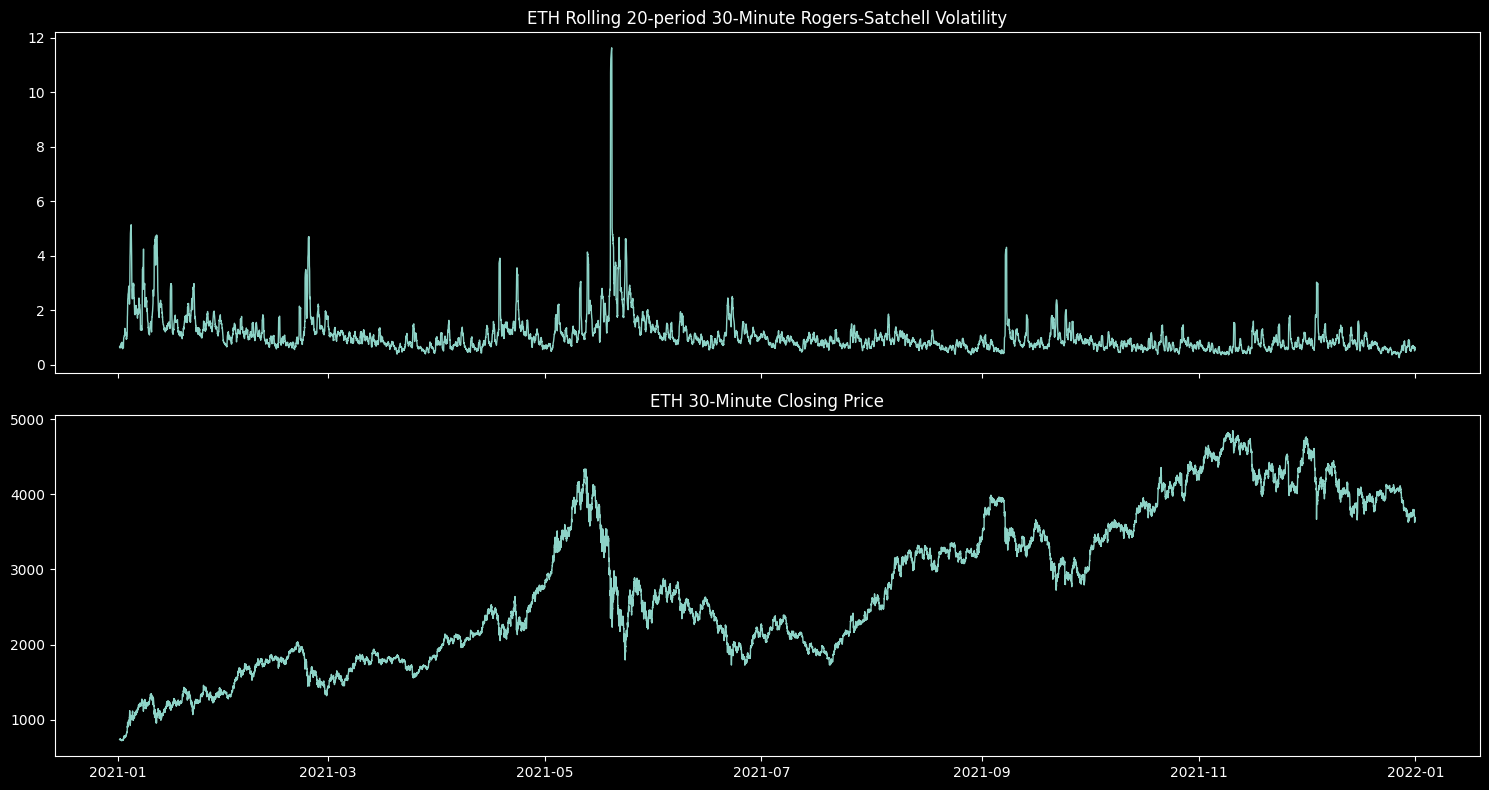

In [13]:
data.plot_price_and_vol()

# Part 1 - Moving Average Crossover

    The strategy we will be implementing will be a moving average crossover strategy utilizing various exponentially weighted moving averages. As a starting point, we will input random parameters and see how the backtest performs, accounting for transaction & funding costs. The most expensive tier for trading perpetuals on Binance incurs taker fees of 3bps per trade, while the average funding rate is 1bp every 8 hours. We will assume our in sample period is all historical data up to but not including 2022.

### Let's test a baseline strategy with a 10/50 crossover

In [14]:
data.set_environment(-0.0003, -0.0001 / 16) #we assume that we incur a 3bp taker fee when we trade along with a 1bp funding costs every 8 hours
data.backtest_simple_crossover(10, 20)

,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,1.189,0.8321,0.356448,1.4757,-0.6344,-0.154884,0.514456


### We can see that we achieved not so great risk-adjusted returns - we can visualize our performance

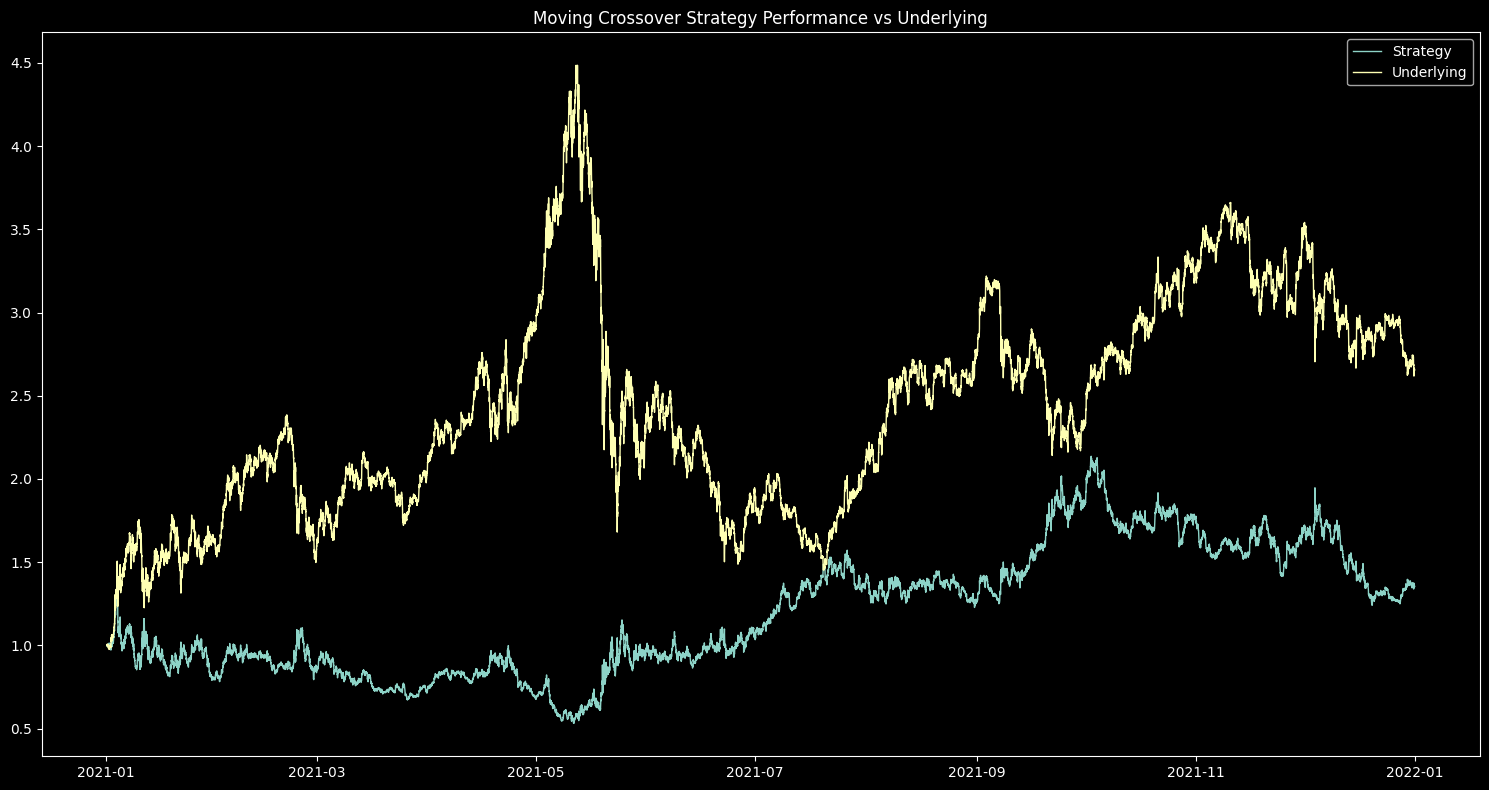

In [15]:
data.plot_performance('2021', '2021')

### We can also visualize what the signals look like for this strategy by looking at a subset of trades.

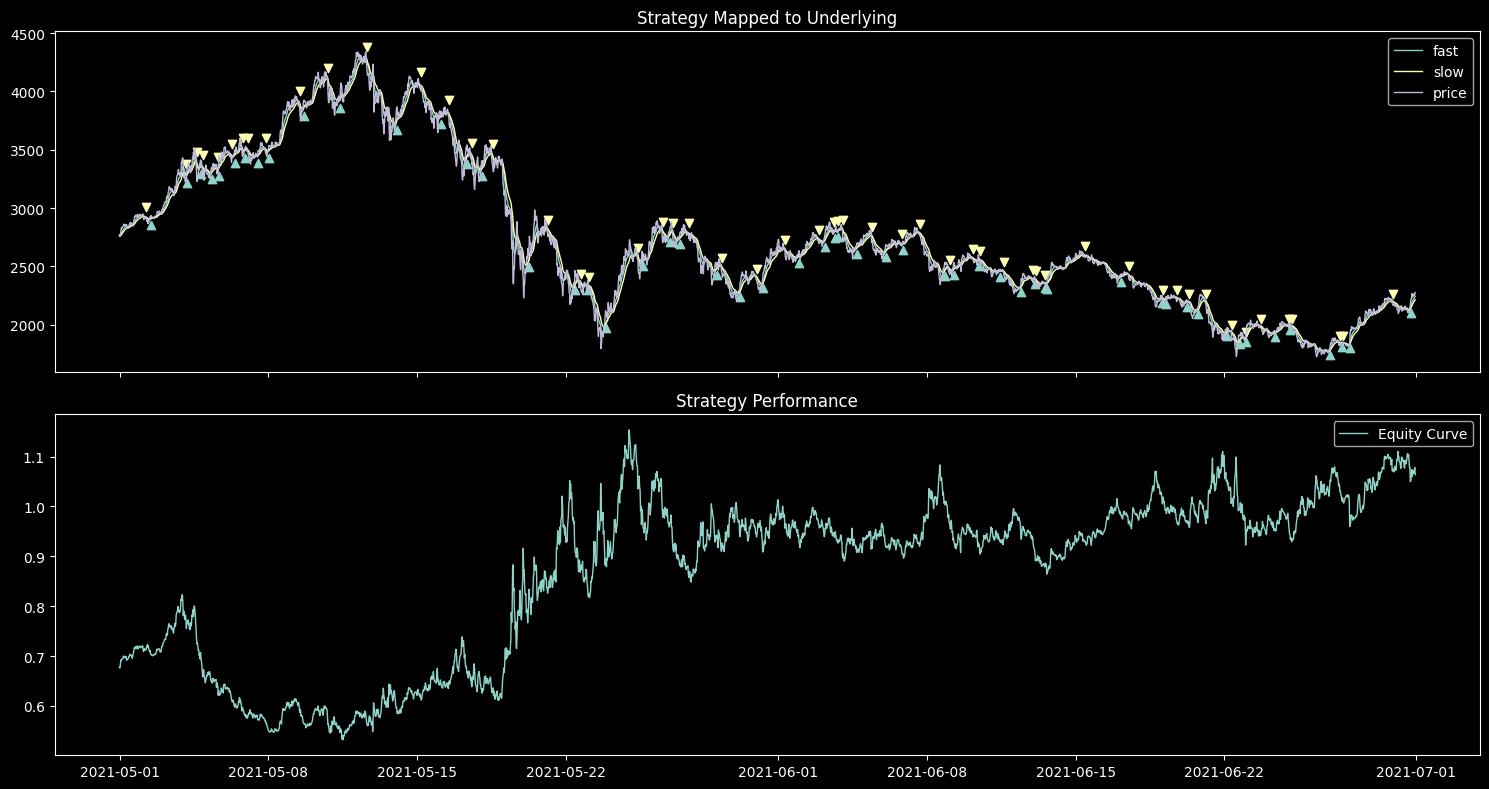

In [16]:
data.evaluate_trades_simple('2021-05-01', '2021-06-30')

### We can write code that will find the best moving averages in our lookback period, conditioned on volatility being above or below its n-period moving average.

In [17]:
vol_list = list(range(100, 501, 100))# list of values that will determine ew vol moving average
ema_list = list(range(10, 301, 10))# list of values that will determing ew price moving averages

optimized_results = data.optimize_complex_strategy_in_sample(vol_list, ema_list)

100%|██████████| 5/5 [3:36:27<00:00, 2597.41s/it]  


### We note that in periods where volatility is less than it's 300-period exponentially weighted moving average, the best crossover pair is the 10/50, and in periods where volatilty is greater than it's 300-period exponentially weighted moving average, the best crossover pair is 120/280. Let's see how this strategy would have performed in sample, then we will evaluate its performance out of sample.

In [ ]:
data.backtest_complex_strategy(10,50,120,280,300)

,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,1.9717,1.5805,2.030556,3.3428,-0.4961,-0.187513,0.403549


### Let's visualize the performance

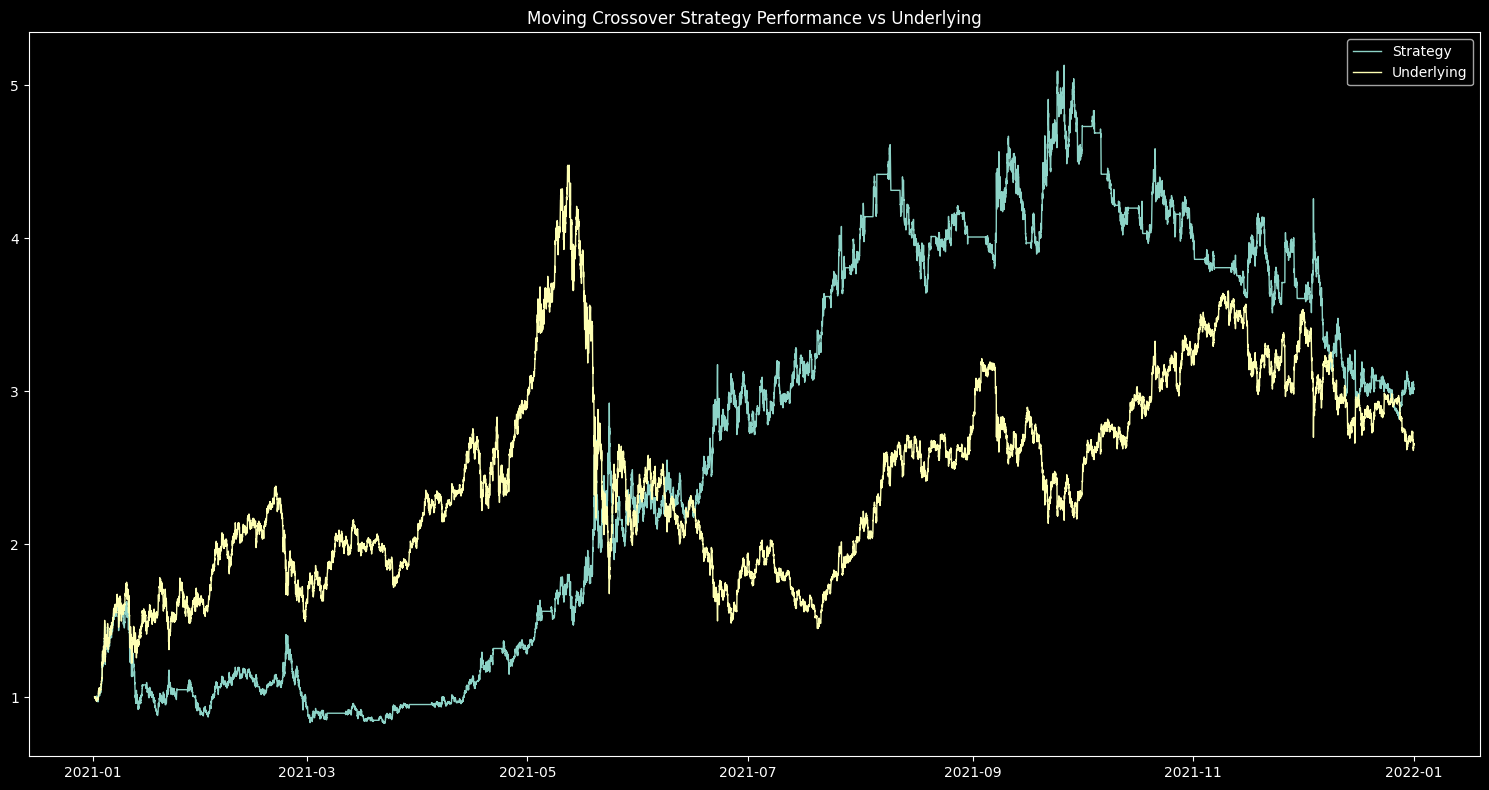

In [633]:
data.plot_performance('2021', '2021')

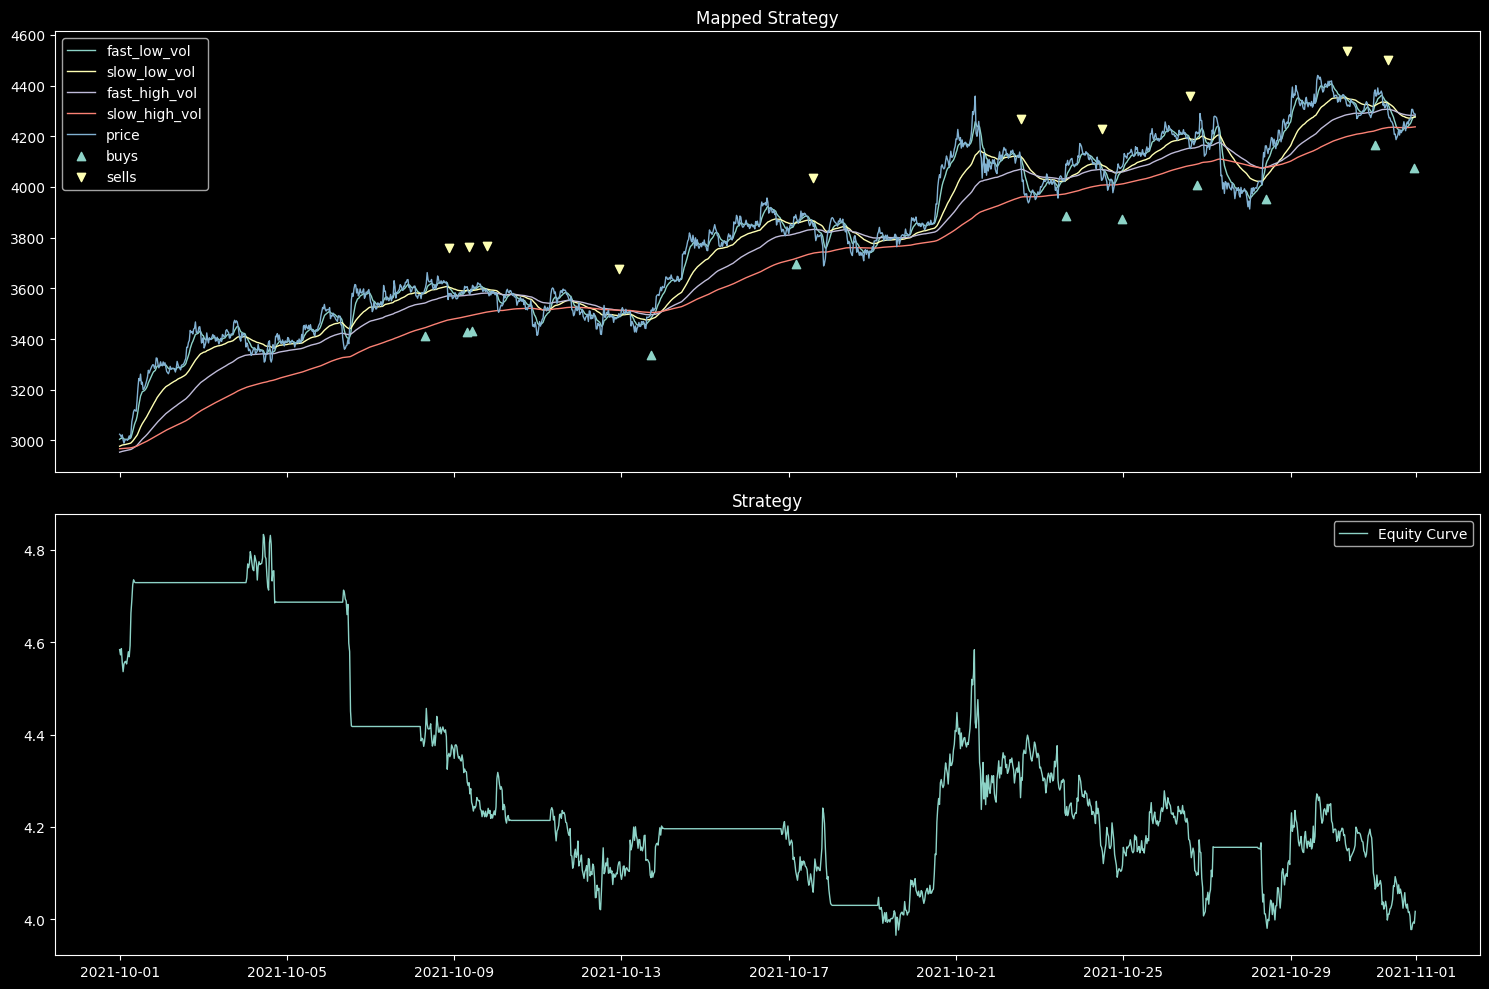

In [635]:
data.evaluate_trades_complex('2021-10-01', '2021-10-31')

### Let's see how our strategy would perform out of sample

In [636]:
out_sample = Backtester(df, '2022', '2022', 20, 48 * 365)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17500 entries, 2022-01-01 10:00:00+00:00 to 2022-12-31 23:30:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_open   17500 non-null  float32
 1   price_close  17500 non-null  float32
 2   price_high   17500 non-null  float32
 3   price_low    17500 non-null  float32
 4   ret          17500 non-null  float32
 5   vol          17500 non-null  float32
 6   vol_ret      17500 non-null  float32
dtypes: float32(7)
memory usage: 615.2 KB


In [637]:
out_sample.set_environment(-0.0003, -0.0001 / 16)
out_sample.backtest_complex_strategy(10,50,120,280,300)

,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,0.8971,0.7501,0.321138,1.2048,-0.5156,-0.326457,-0.065907


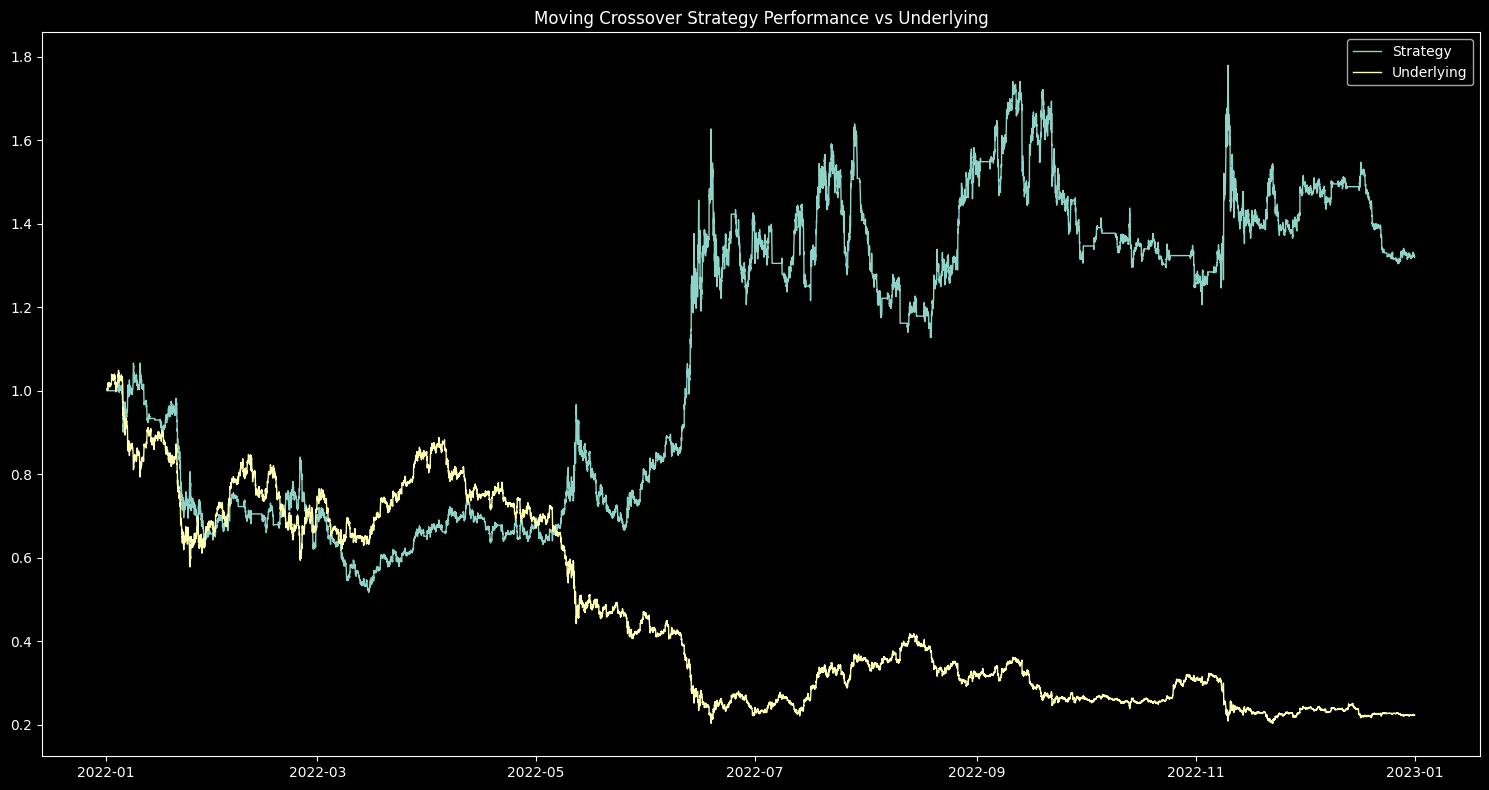

In [638]:
out_sample.plot_performance('2022', '2022')

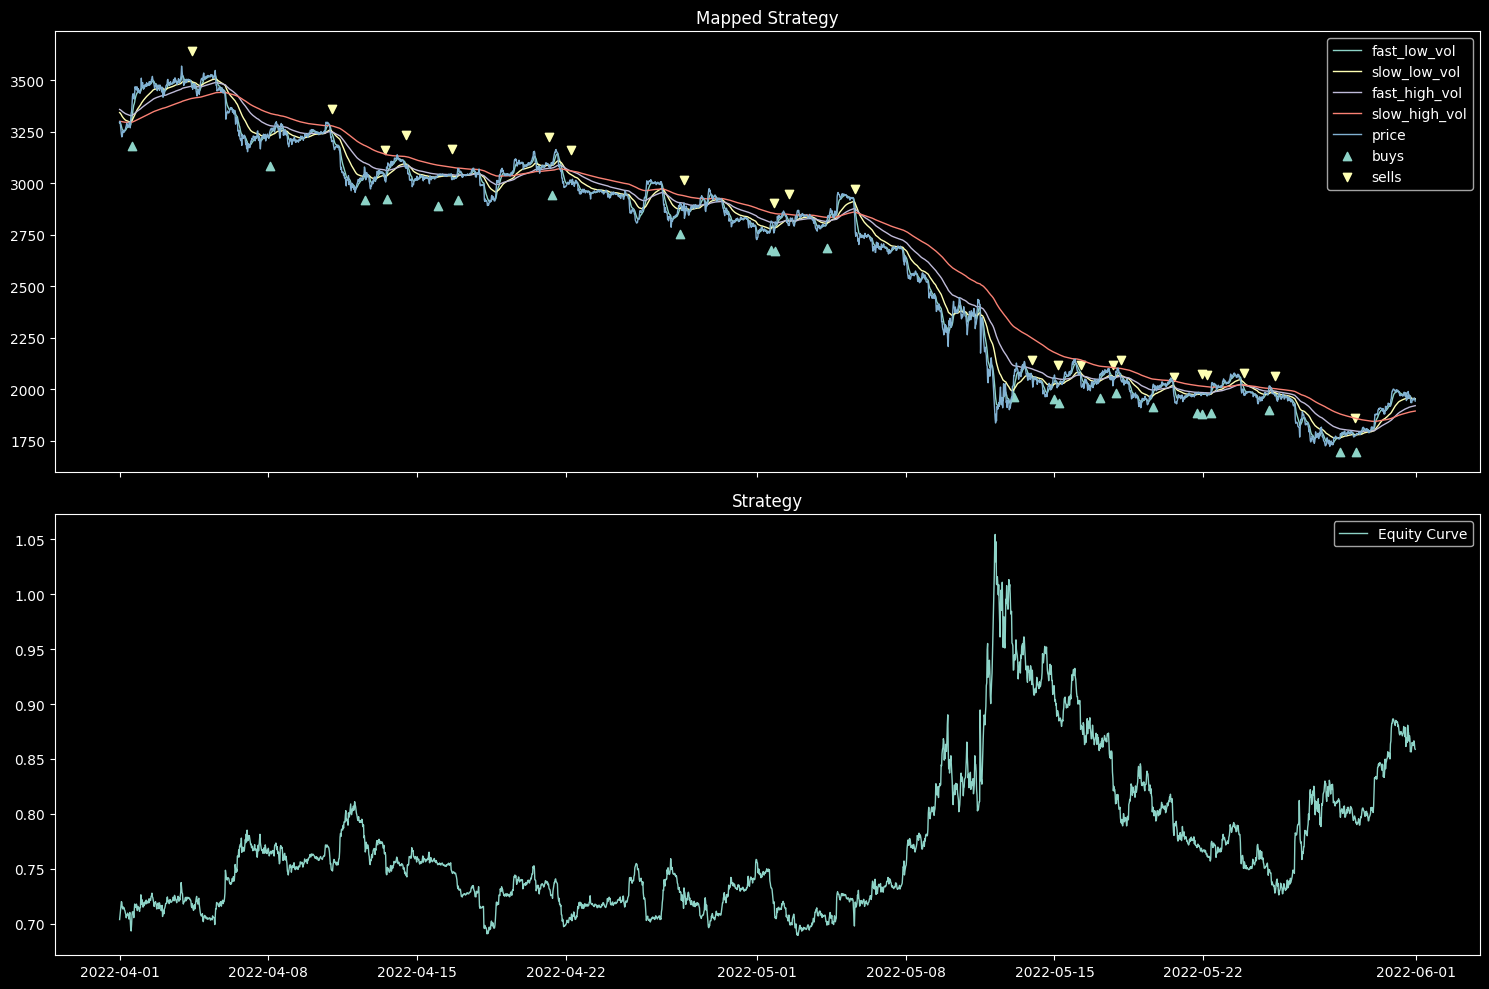

In [550]:
out_sample.evaluate_trades_complex('2022-04-01', '2022-05-31')

In [551]:
out_sample.backtest_complex_strategy(10, 50, 120, 280, 300)

,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,0.8454,0.6529,0.209446,1.1264,-0.5028,-0.282226,-0.061609


In [552]:
data.backtest_complex_strategy(10, 50, 120, 280, 300)

,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,2.2482,1.6304,2.327133,3.4401,-0.5332,-0.081972,0.284196


### As expected, our in-sample results look a lot better than our out of sample results. How can we mitigate this effect?

# Part 2 - Price Path Simulation

    As we have seen, the out-of-sample results are worse than how our strategy performed in-sample. Choosing parameters is prone to overfitting. We can find optimal trading parameters by using stochastic calculus to trade on simulated price paths. We will utilize the Heston Model:

\begin{align}
dS_t = \mu S_t dt + \sqrt{\nu_t} S_t dW^S_t
\tag{1}
\end{align}

\begin{align}
d\ln{\sqrt{\nu_t}} = \theta(\mu - \ln{\sqrt{\nu_t}})dt + \sigma dW^\nu_t
\tag{2}
\end{align}

where $\nu_t$ is the instantanous variance and $W^S_t$, $W^\nu_t$ are Wiener processes with correlation $\rho$. The reason why a Heston Model is an appropriate fit here is due to the fact that volatility and returns are often negatively correlated when markets sell off. Note that the point of our analysis is to simulate price paths, not price a derivative, therefore we are not using Girsanov's Theorem to change to risk neutral measure. We are staying in $\mathbb{P}$ space because that is where we are trading. We know that volatility is a mean-reverting process that is always >= 0, which is why fitting an Exponential Ornstein Uhlenbeck process to the log volatility would give us parameters to simulate price paths. The process for how to use OLS to calibrate an OU process is detailed here: https://advancesincontinuousanddiscretemodels.springeropen.com/articles/10.1186/s13662-018-1718-4

In order to estimate the drift for our GBM, we will first assume that that $\sigma$ = 0 to make it a deterministic model.

\begin{align}
X_t = x_0 e^{\mu t}
\tag{3}
\end{align}

<center> Then, we can transform this into a linear model by taking the natual log of both sides of the equation.

\begin{align}
ln X_t = ln x_0 + \mu t
\tag{4}
\end{align}

\begin{align}
\mu = ln X_t - ln x_0
\tag{5}
\end{align}

<center> where t = 1, since we will only simulate 1 year of data.
<br>

<h5 style='text-align: left;'> The point of this analysis is to simulate price paths that are statistically similar to the one path realized in 2021 so we don't overfit our strategy to one specific path. By simulating many paths that resemble similar statistical characteristics, we can trade on each one and find parameters that on average maximize or minimize certain trading strategy characteristics.

In [48]:
sim = Simulator(df, 1 / (48 * 365), 1000, 20, '2021', '2021')

### We can visualize the rolling correlation between returns and change in volatility

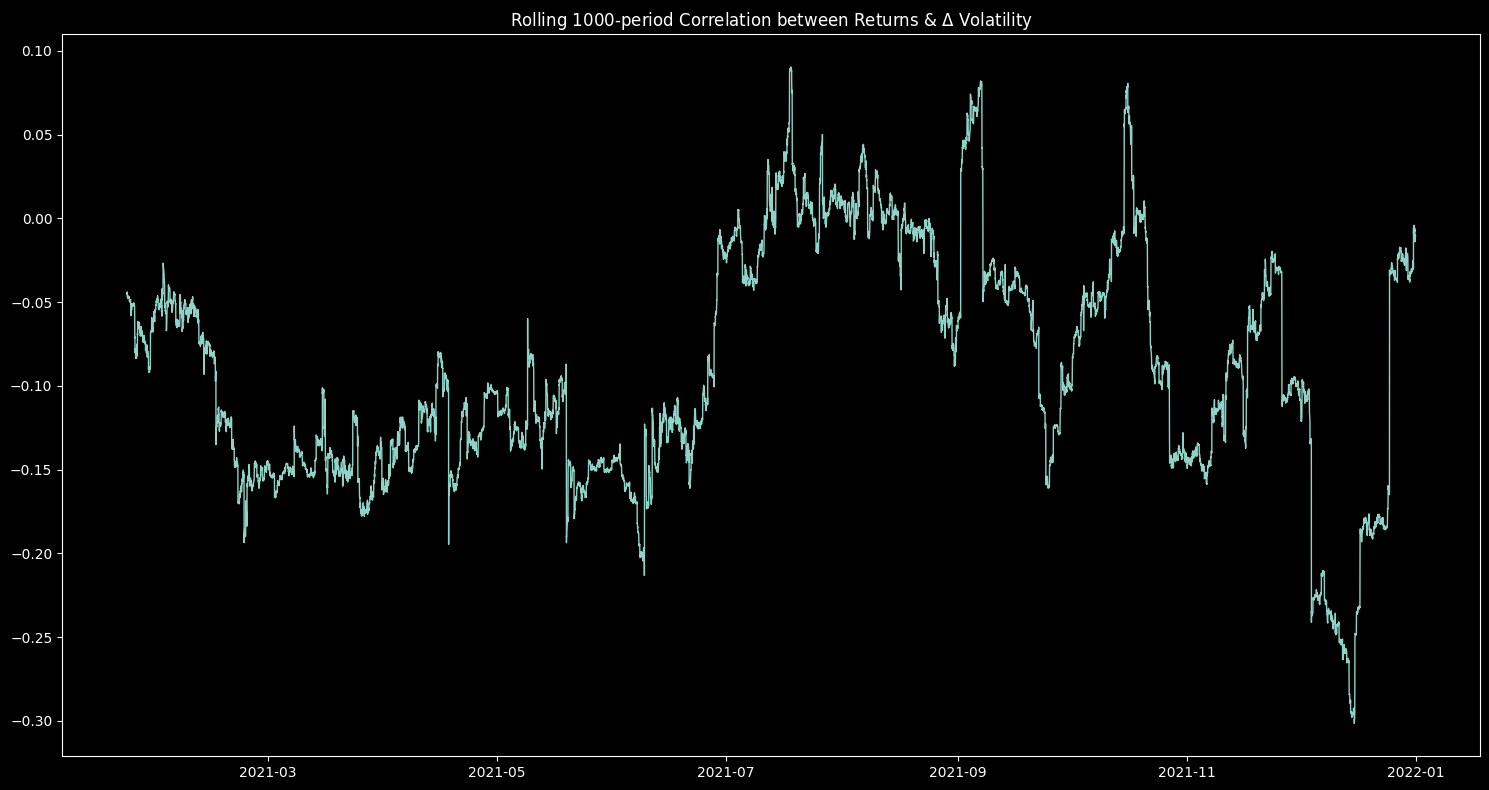

In [49]:
sim.plot_rolling_correlation()

### We can also visualize what the drift component looks like in our GBM

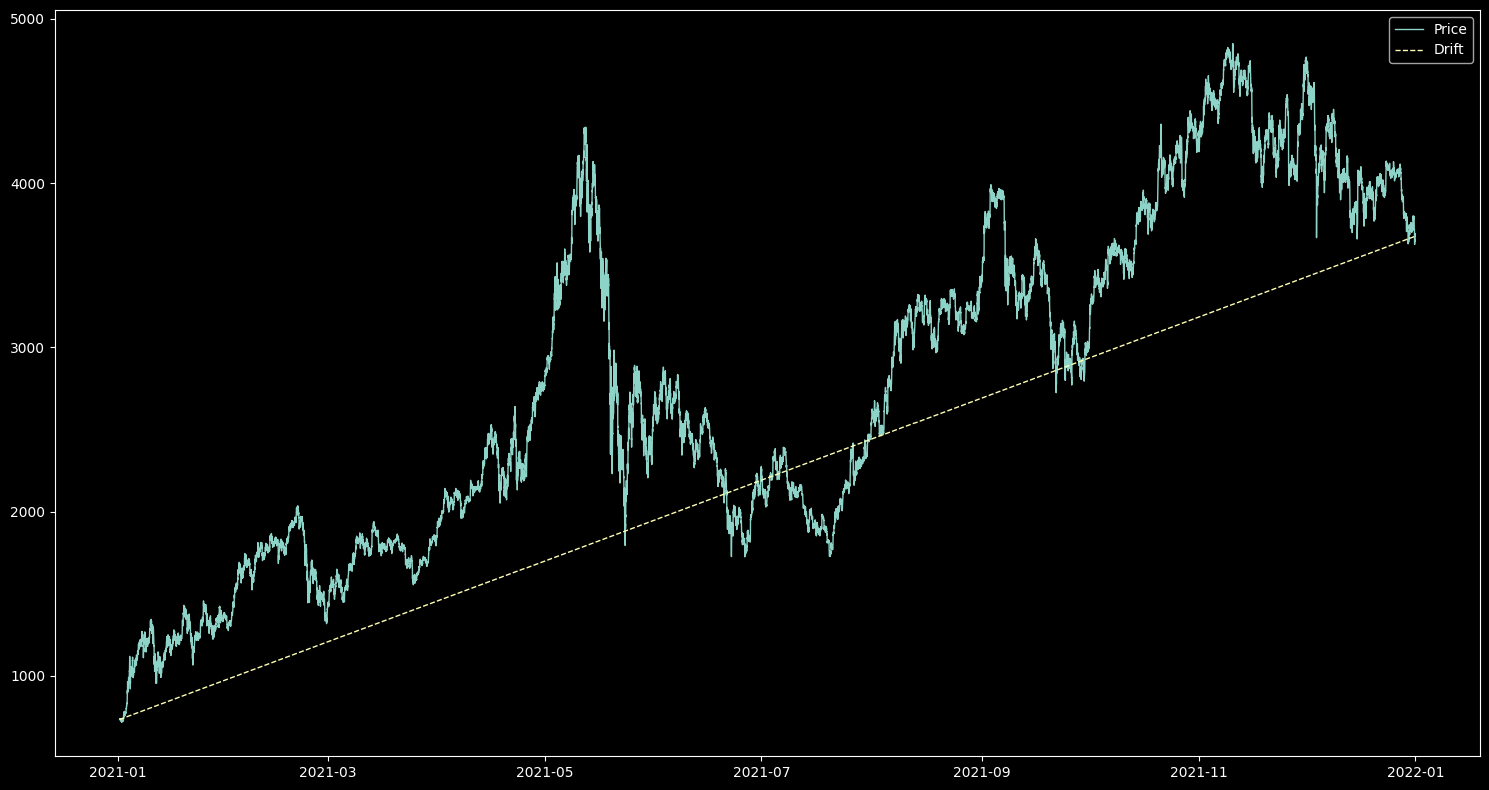

In [50]:
sim.plot_price_with_drift()

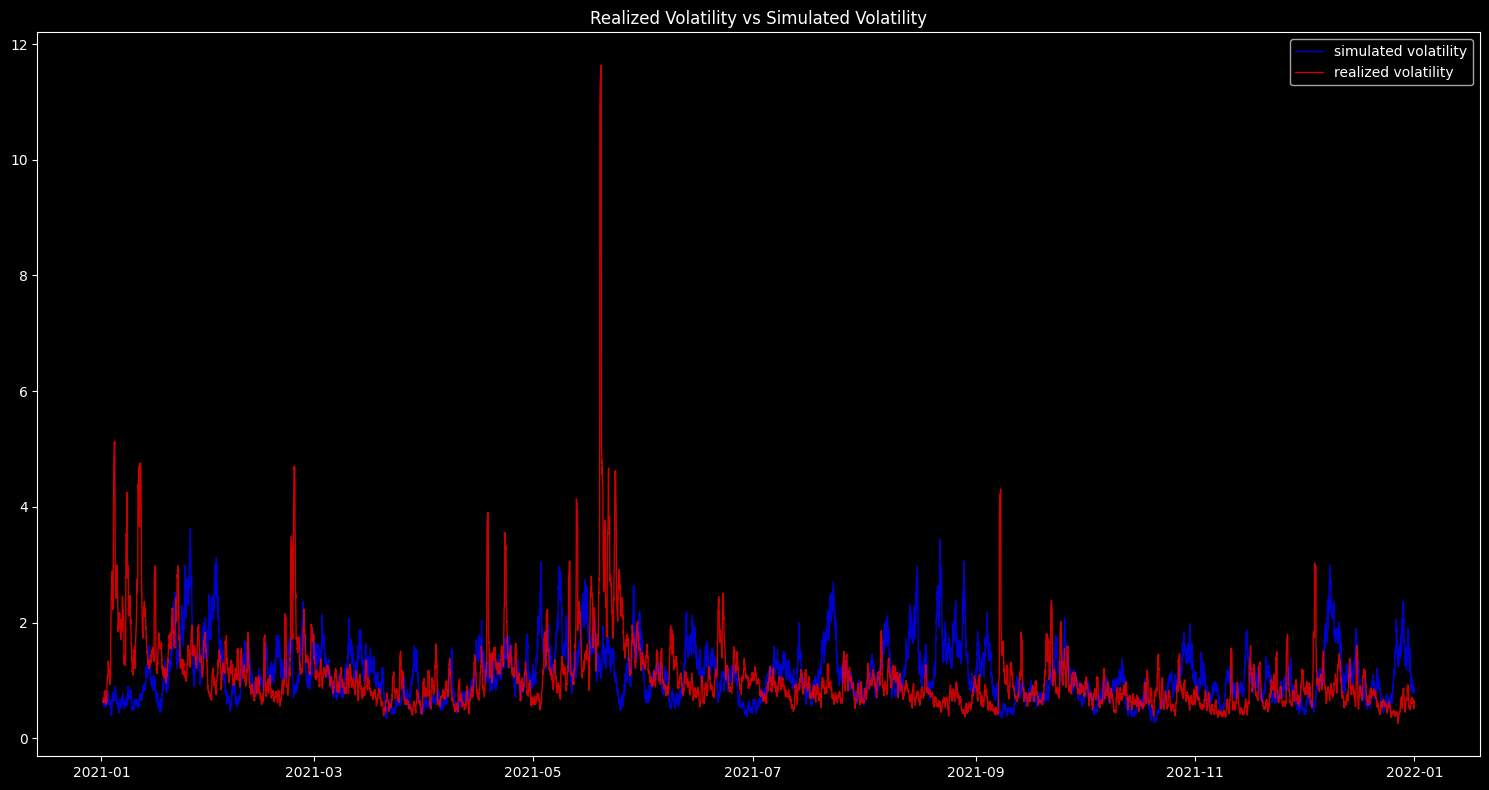

In [51]:
sim.simulate_price_vol_corr()
sim.plot_volatility_comparison()

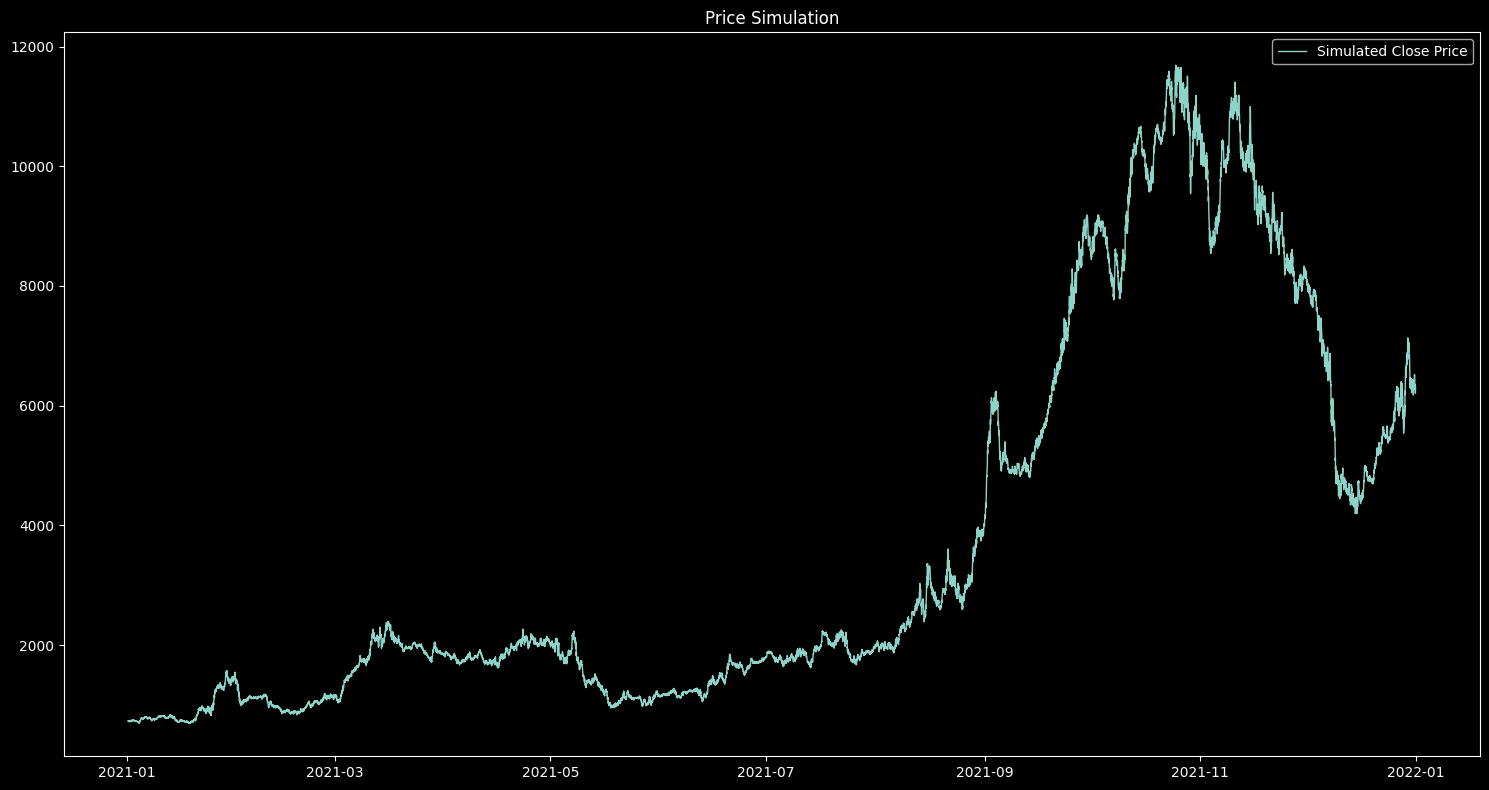

In [52]:
sim.plot_simulated_price()

### Now we can simulate price paths using the model that we just fit.

In [377]:
dir = 'C:/Users/16318/research/Research/PathSimulations/Crypto/ETH/Resolutions/30Minute'
for _ in tqdm(range(1, 1001)):
    sim.simulate_price_vol_corr()
    sim.save_simulation(dir, _)

100%|██████████| 1000/1000 [17:08<00:00,  1.03s/it]


# Part 3 - Simulated Price Path Optimization

    Once we have simulated our price paths, we can run the same analysis we ran before, except we can run the optimization on simulated price paths instead of the one price path that was realized historically.

In [32]:
dir = 'C:/Users/16318/research/Research/PathSimulations/Crypto/ETH/Resolutions/30Minute'
ema_list = list(range(10, 301, 10))
vol_list = list(range(100, 501, 100))
optimization = Backtester(df, '2021', '2021', 20, 48 * 365)
optimization.set_environment(-0.0003, -0.0001 / 16)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17472 entries, 2021-01-01 10:00:00+00:00 to 2021-12-31 23:30:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_open   17472 non-null  float32
 1   price_close  17472 non-null  float32
 2   price_high   17472 non-null  float32
 3   price_low    17472 non-null  float32
 4   ret          17472 non-null  float32
 5   vol          17472 non-null  float32
 6   vol_ret      17472 non-null  float32
dtypes: float32(7)
memory usage: 614.2 KB


### Let's try to maximize our Sortino Ratio

In [ ]:
optimization_results = optimization.optimize_complex_strategy_simulated_paths(ema_list, vol_list, dir)
optimization_results.reset_index().groupby('index').mean().sort_values('Sortino', ascending=False).head()

### As we can see, the results are not promising. We suffer a huge drawdown and we are barely profitable on average. There are a couple of things we can point out regarding what we can fix, but we will address those in the conclusion.

In [593]:
out_sample_optimization_results = Backtester(df, '2022', '2022', 20, 48 * 365)
out_sample_optimization_results.set_environment(-0.0003, -0.0001 / 16)
out_sample_optimization_results.backtest_complex_strategy(50, 60, 140, 300, 300)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17500 entries, 2022-01-01 10:00:00+00:00 to 2022-12-31 23:30:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_open   17500 non-null  float32
 1   price_close  17500 non-null  float32
 2   price_high   17500 non-null  float32
 3   price_low    17500 non-null  float32
 4   ret          17500 non-null  float32
 5   vol          17500 non-null  float32
 6   vol_ret      17500 non-null  float32
dtypes: float32(7)
memory usage: 615.2 KB


,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,-0.0289,-0.0222,-0.32687,-0.0329,-0.584,-0.329363,0.270729


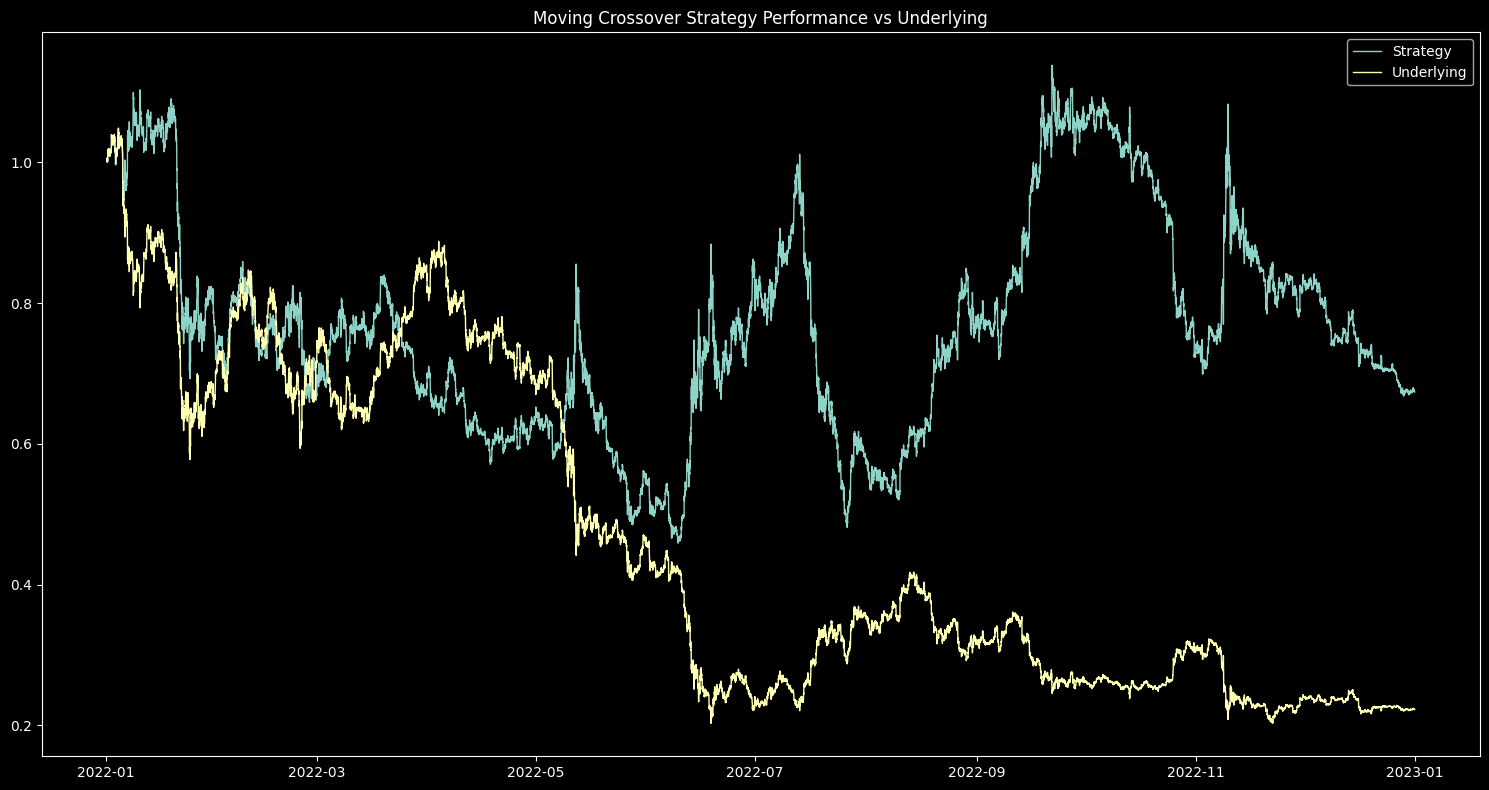

In [594]:
out_sample_optimization_results.plot_performance('2022', '2022')

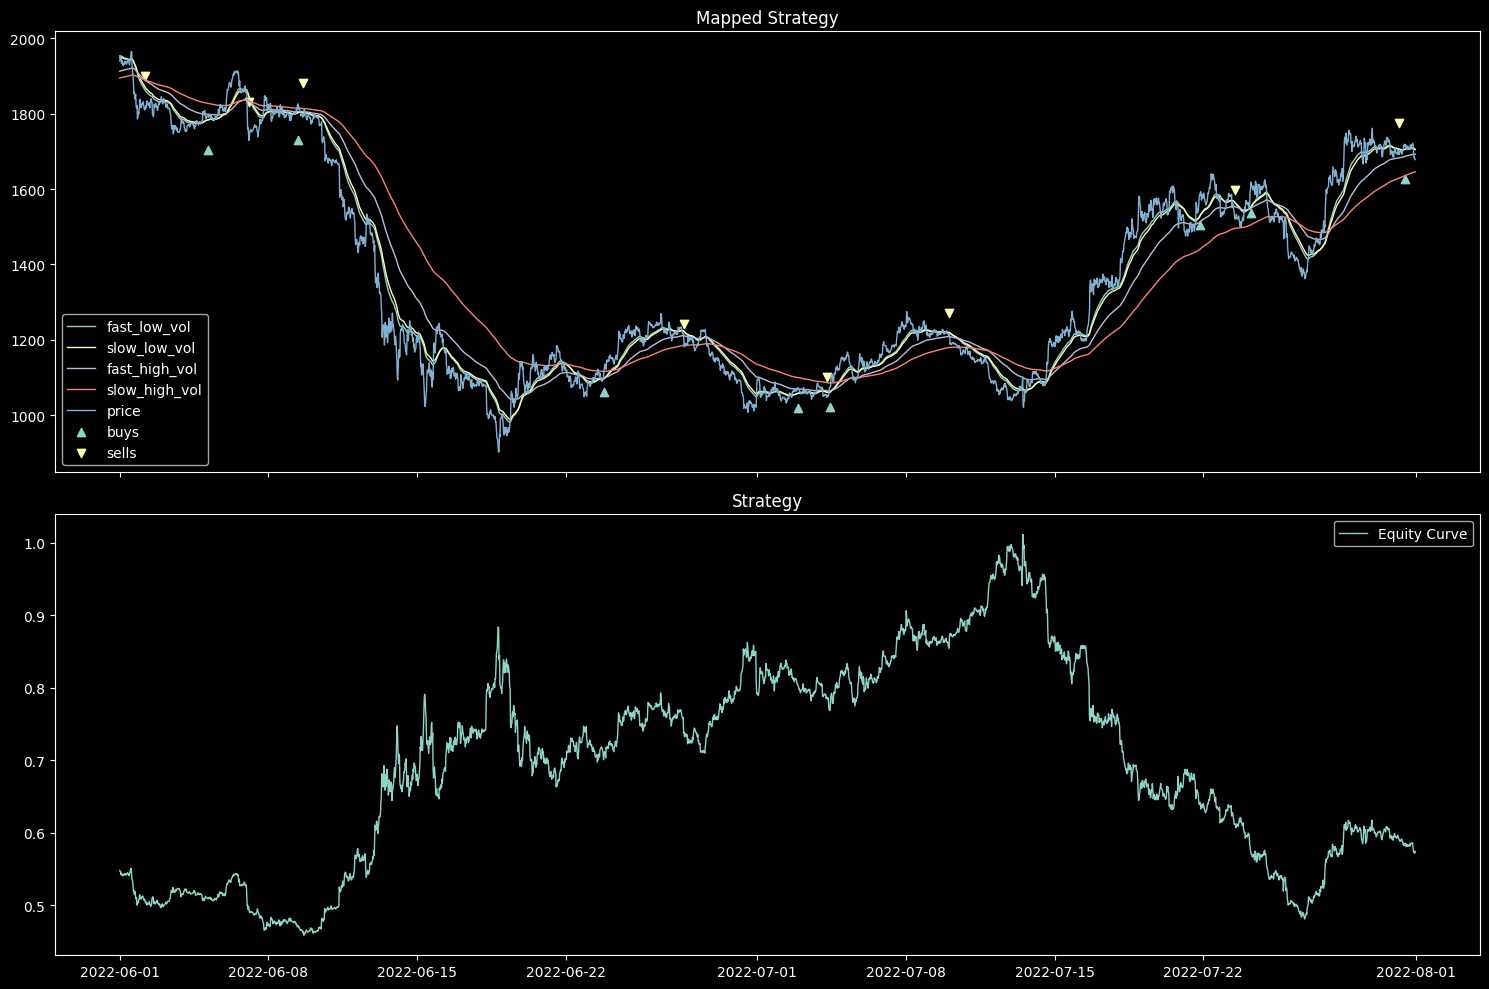

In [595]:
out_sample_optimization_results.evaluate_trades_complex('2022-06-01', '2022-07-31')

# Conclusion

    While our out of sample results were disappointing, it is worthy to note that the parameters we were given from the price path optimization led to robust risk-return ratios and performance on the realized price path in-sample. These results were better than the results we originally optimized for, which is interesting. It is possible that these parameters performed best by chance, but it would be worthy to note what the distribution of Sortino ratios looks like in our price path optimizations. The in-sample results with the new parameters is given below.

In [597]:
in_sample_optimization_results = Backtester(df, '2021', '2021', 20, 48 * 365)
in_sample_optimization_results.set_environment(-0.0003, -0.0001 / 16)
in_sample_optimization_results.backtest_complex_strategy(50, 60, 140, 300, 300)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17472 entries, 2021-01-01 10:00:00+00:00 to 2021-12-31 23:30:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_open   17472 non-null  float32
 1   price_close  17472 non-null  float32
 2   price_high   17472 non-null  float32
 3   price_low    17472 non-null  float32
 4   ret          17472 non-null  float32
 5   vol          17472 non-null  float32
 6   vol_ret      17472 non-null  float32
dtypes: float32(7)
memory usage: 614.2 KB


,Sortino,Sharpe,CAGR,Calmar,Max Drawdown,Beta,Skew
Strategy,3.7694,2.7492,10.708062,7.2762,-0.425,0.085402,0.278169


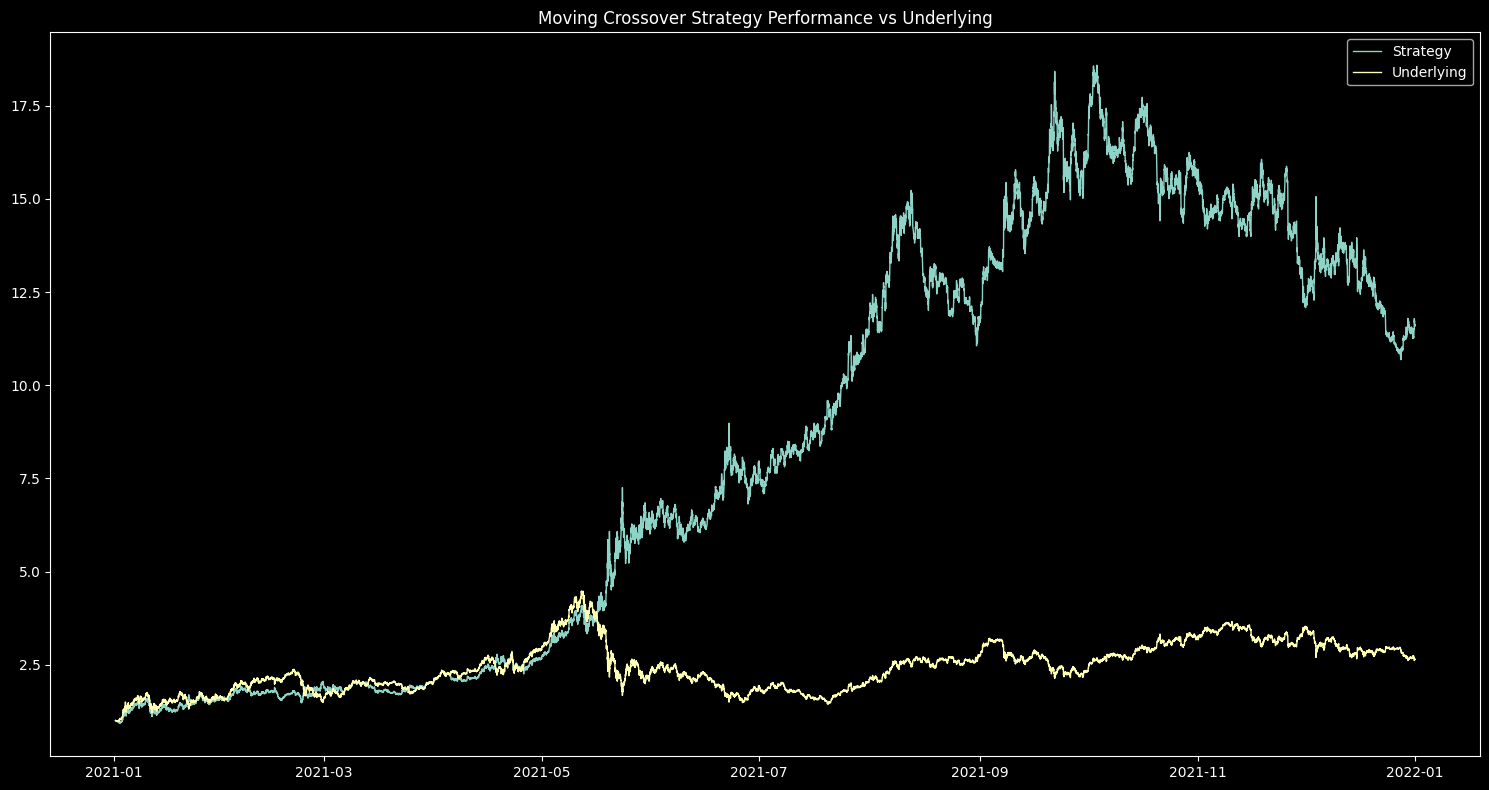

In [598]:
in_sample_optimization_results.plot_performance('2021', '2021')

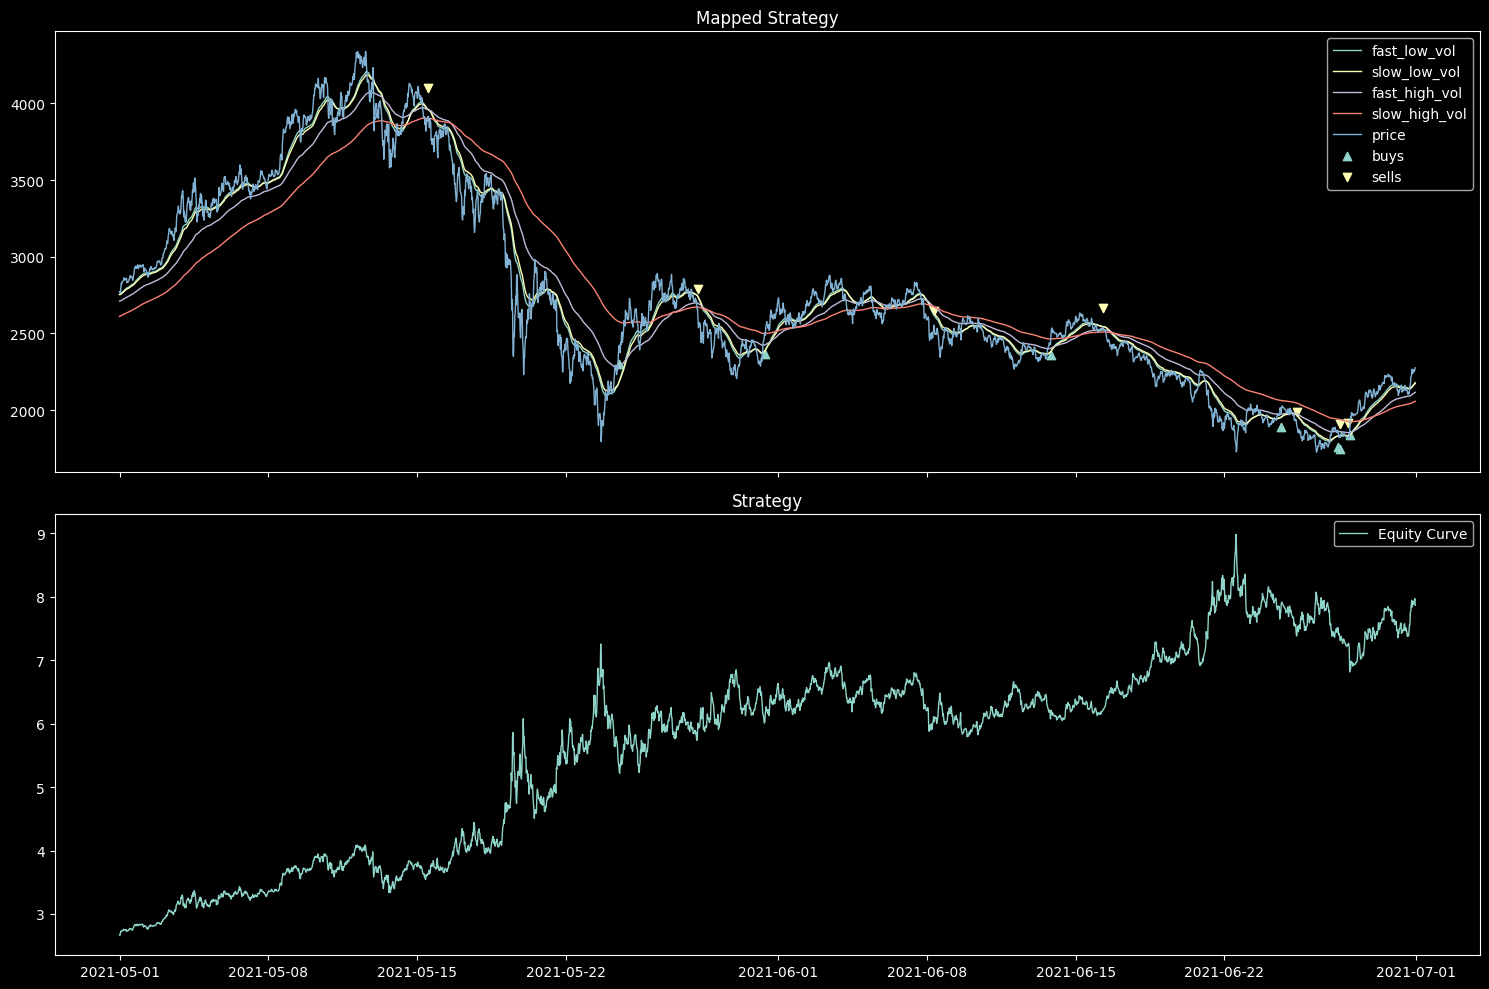

In [599]:
in_sample_optimization_results.evaluate_trades_complex('2021-05-01', '2021-06-30')

# Improvements/Ideas moving forward

    1. We used exponentially weighted moving averages. Using something like a Kalman Filter or other types of signal processing filters may lead to more robust results.
    2. Vectorization using Numba would have been incredible helpful and sped up work flow. I tried using Numba at first but that package is definitely a bit finicky at times. However, I think that it is worthwhile to go back and utilize only numpy arrays in the backtests instead of utilizing pandas dataframes.
    3. I think the assumptions regarding our simulated price paths and calibration methods could be improved. Maybe a Heston Model isn't the best model to use to simulate realistic price paths. It was definitely strange that our best average Sortino Ratio amongst the simulated price paths was about 0.02, which leads me to belive that the either the mean may not be the best estimator of location for those ratios or that a trading strategy like this one would truly perform horribly on unseen data. 
    4. The parameterization of the strategy itself (entry/exit signals, stop loss/take profit schemes) could be suboptimal as they are now. Would have to think about how these parameters could be improved or integrated in our framework.